# COVID-19 Development in Hamburg, Germany

This notebook will show the development of COVID-19 in Hamburg.

## Source of the data

[Hamburg.jl](https://github.com/oem/Hamburg.jl) provides information to all the datasources used. To summarize: The datasources are all "official" and either from the RKI or the official corona page of the city of Hamburg.

In [6]:
using Pkg
Pkg.add("StatsPlots")

  Resolving package versions...
No Changes to `~/src/oem/Hamburg.jl/Project.toml`
No Changes to `~/src/oem/Hamburg.jl/Manifest.toml`


In [1]:
using Hamburg

In [232]:
using Dates, DataFrames, TimeSeries, StatsPlots, Statistics, Plots

gr(size=(800,400))
Plots.theme(:vibrant)

infected = dataset("covid-19", "infected")
DataFrames.head(infected, 5)

,deaths,hospitalizations,intensivecare,new,recordedat,recovered,total
,Int64?,Int64?,Int64?,Int64,Date,Int64?,Int64
1,241,71,20,204,2020-10-20,7800,10205
2,241,59,17,93,2020-10-19,7700,10001
3,241,59,17,162,2020-10-18,7700,9908
4,241,58,17,131,2020-10-17,7600,9746
5,241,58,17,160,2020-10-16,7500,9615


## Total cases

The total numbers for recoveries and deaths did have a slight mismatch between the RKI and the Hamburg Corona page. That's why there are only plots of those values from july onwards. That was the time when recording from the Hamburg Corona page started.

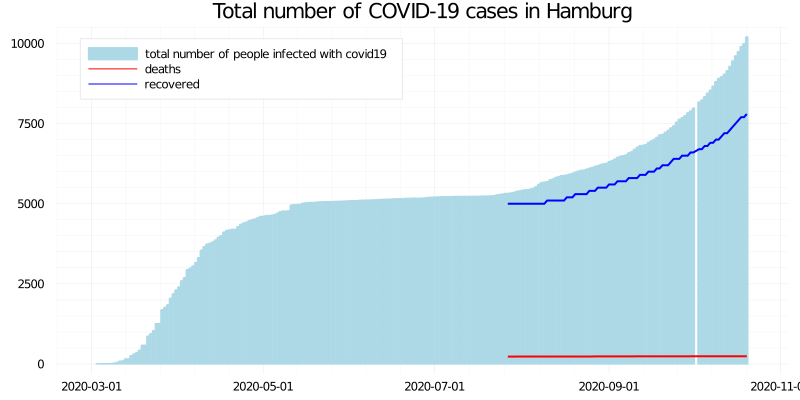

In [233]:
ta = TimeArray(infected, timestamp=:recordedat)
fromjuly = from(ta, Date(2020, 7, 1))

bar(ta[:total],
    linecolor=:lightblue,
    c=:lightblue,
    legend=:topleft,
    size=(800, 400),
    label="total number of people infected with covid19",
    title="Total number of COVID-19 cases in Hamburg")
plot!(fromjuly[:deaths], c=:red, lw=2)
plot!(fromjuly[:recovered], c=:blue, lw=2)

## New cases

### Looking at the last seven days: lockdown or not

The senate will need to decide on stricter measures if there are **950 or more** new cases in the last seven days.

In [234]:
lastweek = infected[1:7, :]
sumlastweek = sum(lastweek.new)
print("$sumlastweek of 950 new cases in the last seven days.")

1053 of 950 new cases in the last seven days.

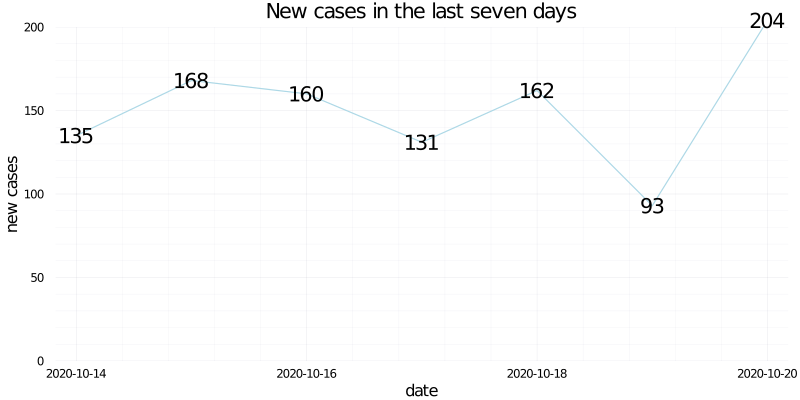

In [235]:
taweek = TimeArray(lastweek, timestamp=:recordedat)
plot(taweek[:new];
    c=:lightblue,
    linecolor=:lightblue,
    label=false,
    series_annotations=string.(values(taweek[:new])),
    title="New cases in the last seven days",
    ylabel="new cases",
    xlabel="date",
    ylim=(0, 200),
    size=(800, 400))

### Looking at the development of new cases over the whole course of the pandemic

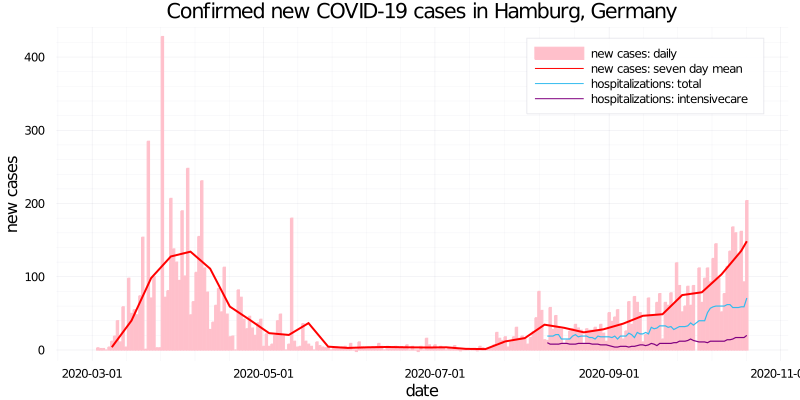

In [236]:
ta = TimeArray(infected.recordedat, convert.(Float64, infected.new), [:new])
collapsed = collapse(ta, week, last, mean)

@df infected bar(reverse(infected.recordedat), reverse(infected.new),
    linecolor=:pink,
    title="Confirmed new COVID-19 cases in Hamburg, Germany",
    ylabel="new cases",
    xlabel="date", 
    label="new cases: daily",
    c=:pink,
    size=(800, 400))

plot!(collapsed, c=:red, label="new cases: seven day mean", lw=2)
plot!(reverse(infected.recordedat), reverse(infected.hospitalizations), label="hospitalizations: total")
plot!(reverse(infected.recordedat), reverse(infected.intensivecare), label="hospitalizations: intensivecare", c=:purple)

## Are there localized hotspots or is the infection rate balanced between the boroughs?

There is even more fine-grained data available showing the development of COVID-19 for each borough. The numbers are aggregated into 14 day intervals. The aggregation happens to protect the privacy of the affected people.

In [237]:
boroughsovertime = dataset("covid-19", "boroughs")
boroughs = select(boroughsovertime, Not(:recordedat))
boroughsmatrix = convert(Matrix, boroughs)
boroughsovertime

,Altona,Bergedorf,Eimsbüttel,Hamburg Mitte,Hamburg Nord,Harburg,Wandsbek,recordedat
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Date
1,163,79,124,172,119,96,208,2020-10-19
2,93,55,67,156,90,60,181,2020-10-12
3,63,39,58,94,109,70,156,2020-10-05
4,69,28,65,97,92,46,123,2020-09-28
5,79,31,83,98,143,43,181,2020-09-21
6,88,23,72,87,126,41,105,2020-09-14
7,79,17,59,88,90,21,73,2020-09-07
8,47,17,43,86,58,22,74,2020-08-31
9,49,15,38,111,36,39,67,2020-08-24


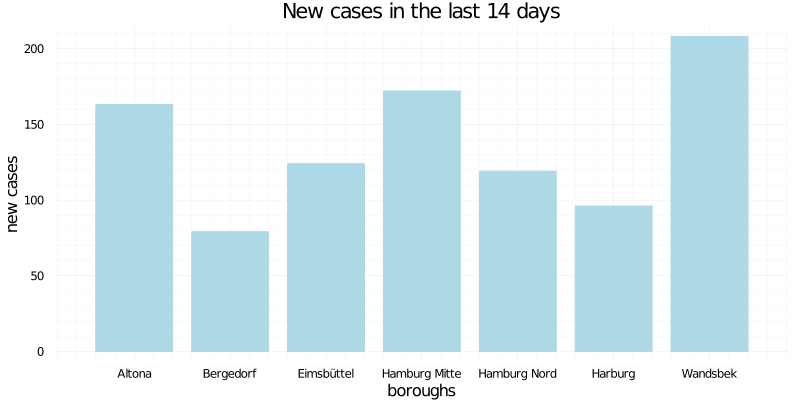

In [238]:
bar(names(boroughs), boroughsmatrix[1, :],
    legend=false, 
    c=:lightblue, 
    linecolor=:lightblue, 
    size=(800,400), 
    title="New cases in the last 14 days", 
    xlabel="boroughs", 
    ylabel="new cases")

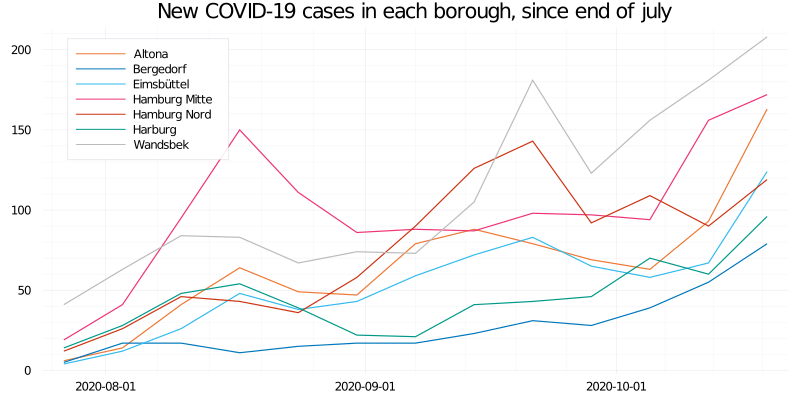

In [239]:
tb = TimeArray(boroughsovertime, timestamp=:recordedat)

plot(tb, legend=:topleft, size=(800,400))
plot!(title="New COVID-19 cases in each borough, since end of july")

## How are different age groups affected by covid-19?

In [223]:
agegroups = dataset("covid-19", "agegroups")
categorical!(agegroups, :age)
first(agegroups, 11)

,recordedat,age,male,female
,Date,Cat…,Int64,Int64
1,2020-10-19,0:5,90,69
2,2020-10-19,6:14,266,221
3,2020-10-19,15:19,274,282
4,2020-10-19,20:29,1155,1044
5,2020-10-19,30:39,937,861
6,2020-10-19,40:49,726,704
7,2020-10-19,50:59,772,672
8,2020-10-19,60:69,367,330
9,2020-10-19,70:79,269,269


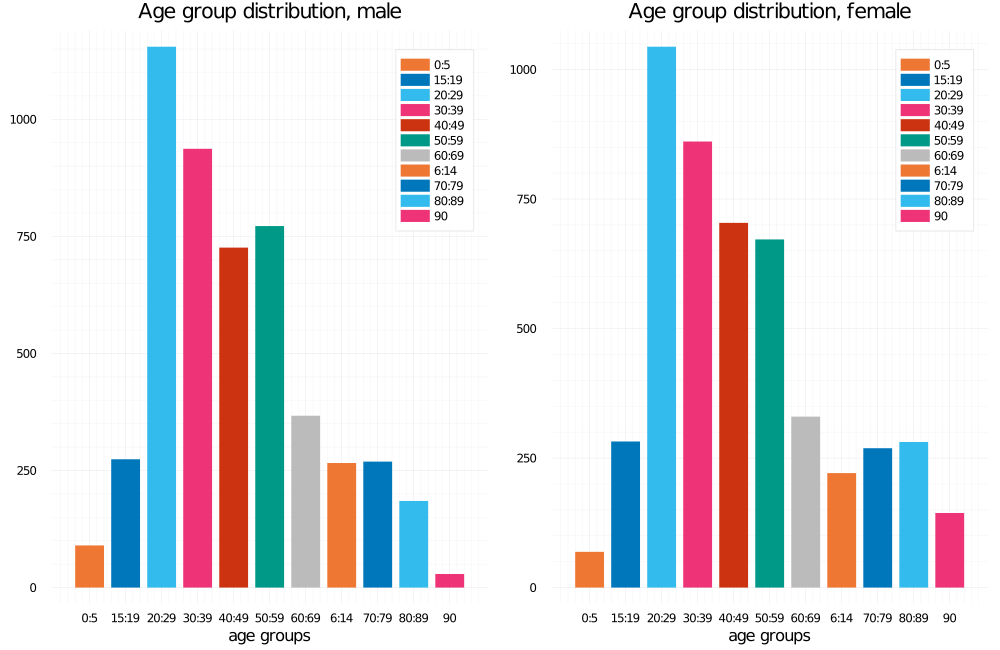

In [228]:
timestamp = agegroups.recordedat |> unique |> maximum
current = filter(r-> r.recordedat == timestamp, agegroups)

p1 = @df current groupedbar(agegroups.age, :male, group=:age, lw=0, xlabel="age groups", title="Age group distribution, male", bar_position=:stack)
p2 = @df current groupedbar(agegroups.age, :female, group=:age, lw=0, xlabel="age groups", title="Age group distribution, female", bar_position=:stack)
plot(p1, p2, size=(1000,650))